In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 16


In [3]:
dfs = InsectImgDataset(directory=DATA_DIR, ext=ext, setting=setting)
dfs.extract_df_info()

Extracting info from filenames..: 100%|█| 30625/30625 [00:03<00:00, 8487


In [4]:
insects = ['v', 'wmv', 'c', 'sw', 't', 'bl', 'm', 'k', 'wrl', 'sp', 'wswl', 'v(cy)']
dfs.df = dfs.df[dfs.df.label.isin(insects)]
dfs.df = dfs.df[~dfs.df['label'].isin(['st','vuil'])]
dfs.df.label = dfs.df.label.apply(lambda x: 'v' if x=='v(cy)' else x)
dfs.df.reset_index(drop=True, inplace=True)
dfs.df.label.value_counts()

wmv     5812
v       5479
c       4575
sw      3025
bl      2406
t       2390
wrl     1874
m       1552
k       1087
sp      1026
wswl     711
Name: label, dtype: int64

100%|███████████████████████████████████| 20/20 [00:00<00:00, 69.28it/s]


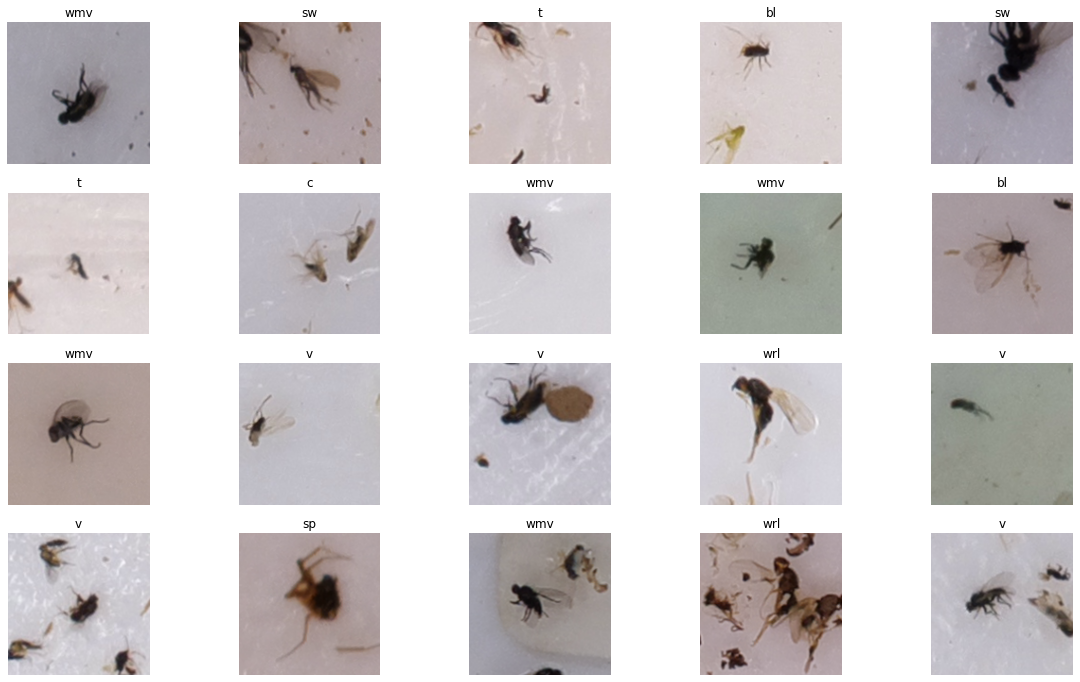

In [5]:
dfs.plot_samples()

# Extra feature collection

In [6]:
batch_size=32
dloader = DataLoader(dfs, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
l_blur_factors = [0]*len(dfs)
l_meansRGB = [0]*len(dfs)
l_stdsRGB = [0]*len(dfs)
l_nb_contours, l_mean_cnt_area, l_mean_cnt_perimeter, l_std_cnt_area, l_std_cnt_perimeter = [0]*len(dfs),[0]*len(dfs),[0]*len(dfs),[0]*len(dfs),[0]*len(dfs)

c=0
for x,l,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(dloader, total=len(dfs)//batch_size, desc='Collecting all data from the dataloader..'):
    for i,f in enumerate(filename):
        l_blur_factors[c] = calc_variance_of_laplacian(f)
        meanRGB, stdRGB = calc_mean_RGB_vals(f)
        l_meansRGB[c] = meanRGB
        l_stdsRGB[c] = stdRGB
        nb_contours, mean_cnt_area, mean_cnt_perimeter, std_cnt_area, std_cnt_perimeter = calc_contour_features(f)
        l_nb_contours[c] = nb_contours
        l_mean_cnt_area[c] = mean_cnt_area
        l_mean_cnt_perimeter[c] = mean_cnt_perimeter
        l_std_cnt_area[c] = std_cnt_area
        l_std_cnt_perimeter[c] = std_cnt_perimeter
        c+=1

  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/kalfasyan/anaconda3/envs/bugai/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
df_rgb = pd.DataFrame(l_meansRGB, columns=['R','G','B'])
df_feats = pd.DataFrame({'blur': l_blur_factors, 
                        'nb_contours': l_nb_contours,
                        'mean_cnt_area': l_mean_cnt_area,
                        'mean_cnt_perimeter': l_mean_cnt_perimeter,
                        'std_cnt_area': l_std_cnt_area,
                        'std_cnt_perimeter': l_std_cnt_perimeter})
df_feats = pd.concat([df_feats, df_rgb], axis=1)
feature_columns = df_feats.columns


df = pd.concat([dfs.df, df_feats], axis=1)
df.sort_values(by='label', inplace=True)

df = df[~df.label.isin(['gv','sl'])]

insect_classes = df.label.unique().tolist()

df.head()

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,nb_contours,mean_cnt_area,mean_cnt_perimeter,std_cnt_area,std_cnt_perimeter,R,G,B
0,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_UNDISTORTED_herent_w28_1-90_4056x3040_202...,UNDISTORTED_herent_w28_1-90_4056x3040_20200703...,2020,herent,w28,1-90,14131,42.842744,4,116.875000,40.238329,132.378423,37.283882,205.431857,204.239418,210.109485
1600,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9480,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9480,29.410180,9,83.888889,36.288103,209.042895,75.158043,164.357556,161.265422,169.441733
1601,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9485,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9485,19.875911,9,57.222222,28.793009,136.593296,37.956864,159.172889,155.252622,163.486533
1602,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9486,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9486,23.337022,13,42.038462,22.875363,108.971496,42.197361,157.248089,153.570533,160.575378
1603,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9487,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9487,19.561551,21,25.571429,14.343826,96.940739,38.886501,158.137644,154.856889,162.425600


# Outlier detection

### Performed per insect class

In [9]:
l_outlier_features = ['blur', 'nb_contours', 'R','G','B']

def class_outliers(df, features, insect='bl'):
    df = df[df.label==insect]
    outlier, outlier_score = detect_outliers(df[features].fillna(0).values, algorithm='KNN')    
    return outlier, outlier_score

df['knn_outlier'], df['knn_outlier_score'] = 0,0
outliers, scores = [],[]
for ins in tqdm(insect_classes, total=len(insect_classes)):
    out, scr = class_outliers(df, l_outlier_features, insect=ins)
    assert len(out) == df[df.label==ins].shape[0]
    outliers.extend(out)
    scores.extend(scr)
    
df['knn_outlier'], df['knn_outlier_score'] = outliers, scores

100%|███████████████████████████████████| 11/11 [00:00<00:00, 20.51it/s]


100%|███████████████████████████████████| 20/20 [00:00<00:00, 50.81it/s]


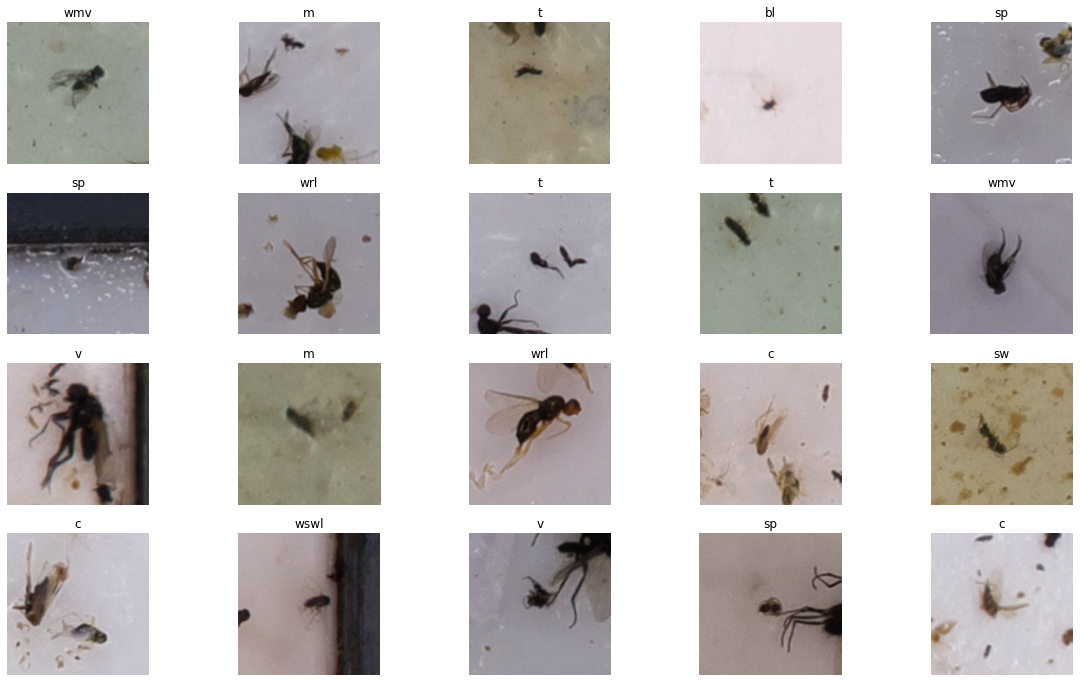

In [10]:
dfs.plot_samples(df[df.knn_outlier==1].sample(20))

In [11]:
df

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,nb_contours,mean_cnt_area,mean_cnt_perimeter,std_cnt_area,std_cnt_perimeter,R,G,B,knn_outlier,knn_outlier_score
0,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2020_UNDISTORTED_herent_w28_1-90_4056x3040_202...,UNDISTORTED_herent_w28_1-90_4056x3040_20200703...,2020,herent,w28,1-90,14131,42.842744,4,116.875000,40.238329,132.378423,37.283882,205.431857,204.239418,210.109485,0,0.133453
1600,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9480,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9480,29.410180,9,83.888889,36.288103,209.042895,75.158043,164.357556,161.265422,169.441733,0,0.155877
1601,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9485,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9485,19.875911,9,57.222222,28.793009,136.593296,37.956864,159.172889,155.252622,163.486533,0,0.088454
1602,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9486,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9486,23.337022,13,42.038462,22.875363,108.971496,42.197361,157.248089,153.570533,160.575378,0,0.158265
1603,/mnt/EE7455C074558BE9/backups/data_backups/ima...,bl,2021_UNDISTORTED_arc_C_w23_4056x3040.png_bl_9487,UNDISTORTED_arc_C_w23_4056x3040.png,2021,arc,w23,c,9487,19.561551,21,25.571429,14.343826,96.940739,38.886501,158.137644,154.856889,162.425600,0,0.173570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29465,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w24_4056x3040.png_ws...,UNDISTORTED_landen_B_w24_4056x3040.png,2021,landen,w24,b,8220,22.121750,13,83.115385,28.787118,215.723216,48.919849,161.846444,157.505111,163.441733,0,0.199894
29466,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w24_4056x3040.png_ws...,UNDISTORTED_landen_B_w24_4056x3040.png,2021,landen,w24,b,8221,20.476336,12,56.833333,21.330459,176.846135,48.222875,167.646578,162.890640,169.288742,0,0.213513
29467,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_landen_B_w25_4056x3040.png_ws...,UNDISTORTED_landen_B_w25_4056x3040.png,2021,landen,w25,b,144,32.118978,15,76.000000,29.039192,270.113433,84.299359,158.944667,154.672844,162.947111,0,0.241136
29447,/mnt/EE7455C074558BE9/backups/data_backups/ima...,wswl,2021_UNDISTORTED_brainelal_c_w40_4056x3040.png...,UNDISTORTED_brainelal_c_w40_4056x3040.png,2021,brainelalleud,w40,c,4228,24.167775,7,105.071429,31.842063,255.331078,69.671348,158.689200,155.320222,160.953689,0,0.135371


In [12]:
print(f"Total of {df[df.knn_outlier==1].shape[0]} outliers found. (# of all datapoints: {df.shape[0]})")
df[df.knn_outlier==1].label.value_counts()

Total of 2996 outliers found. (# of all datapoints: 29937)


wmv     582
v       548
c       458
sw      303
bl      241
t       238
wrl     188
m       156
k       109
sp      102
wswl     71
Name: label, dtype: int64

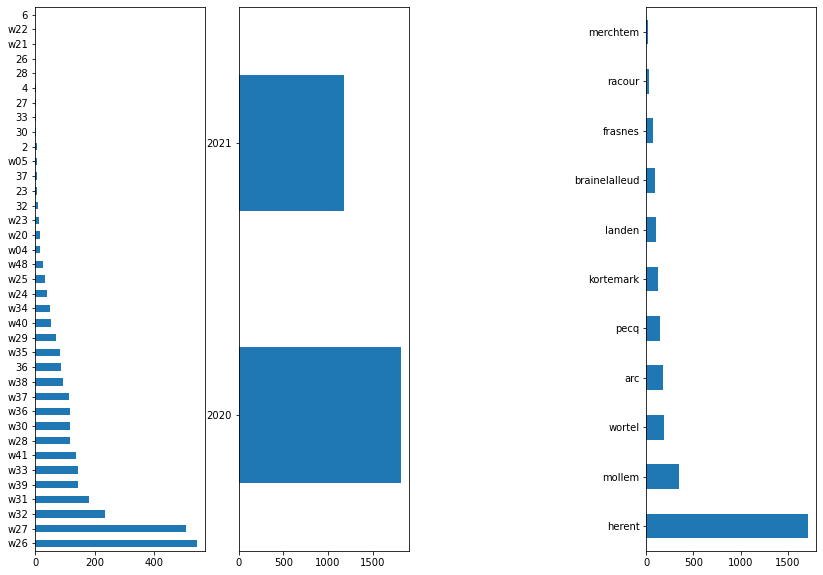

In [13]:
plt.figure(figsize=(24,12))
plt.subplot(1,4,1);
df[df.knn_outlier==1].date.value_counts().plot(kind='barh', figsize=(14,10));
plt.subplot(1,4,2);
df[df.knn_outlier==1].year.value_counts().plot(kind='barh', figsize=(14,10));
plt.subplot(1,4,4);
df[df.knn_outlier==1].location.value_counts().plot(kind='barh', figsize=(14,10));

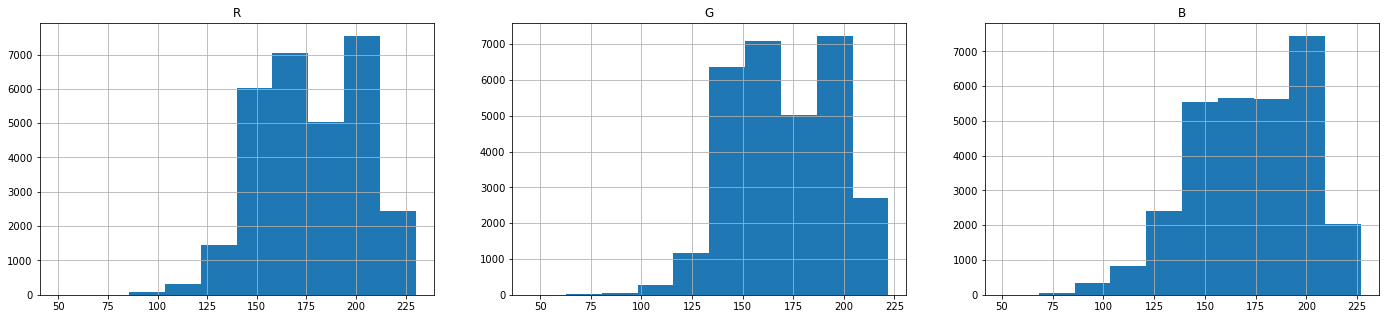

In [14]:
plt.figure(figsize=(24,5))
plt.subplot(1,3,1);
df.R.hist();plt.title('R')
plt.subplot(1,3,2);
df.G.hist();plt.title('G')
plt.subplot(1,3,3);
df.B.hist();plt.title('B');

100%|███████████████████████████████████| 20/20 [00:00<00:00, 54.89it/s]


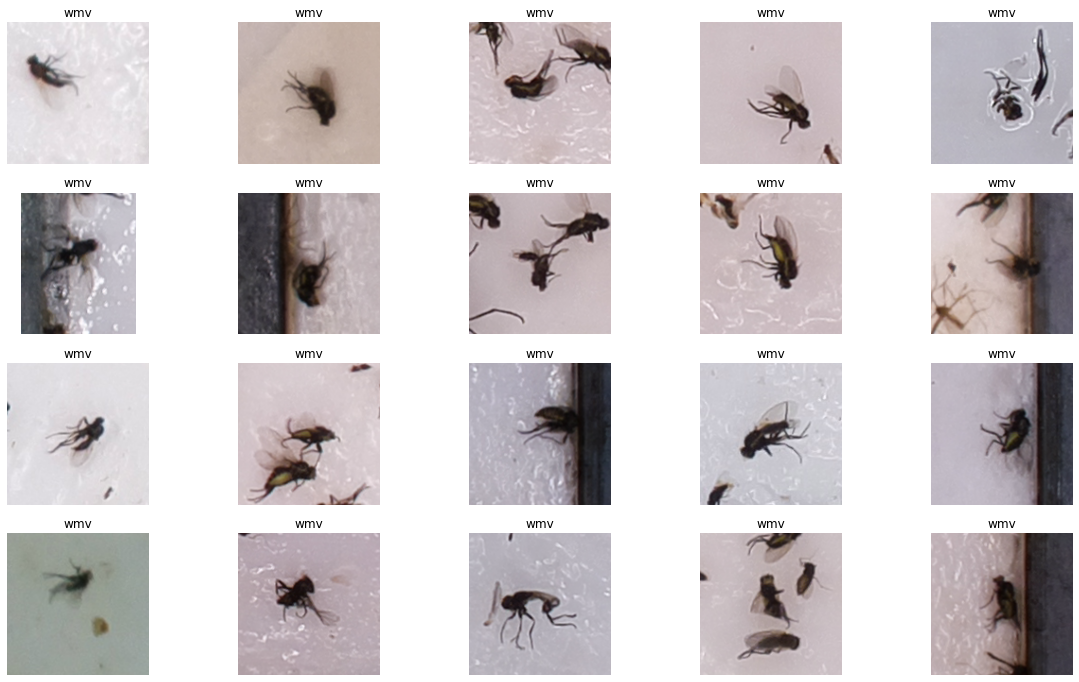

In [15]:
selection = 'label==\'wmv\' & knn_outlier==1 & nb_contours<15'
# selection = 'knn_outlier==1 & label==\'wmv\''
dfs.plot_samples(df.query(selection).sample(20))

In [16]:
df.query(selection).date.value_counts()

w38    20
w36    10
w39     8
w33     7
w32     6
w34     4
w40     4
w37     4
w30     3
w27     2
w28     2
w31     1
w35     1
w29     1
Name: date, dtype: int64

# CALCULAE IF INSECT IS CLOSER TO THE EDGE OF FOTO

In [17]:
# df[df.knn_outlier==0]

In [18]:
df['plate_idx'] = df['plate_idx'].astype('int64')
df['year'] = df['year'].astype('int64')

df_allinfo = pd.read_csv("../stickybugs/modelling/df_allinfo.csv", index_col='Unnamed: 0')
df_allinfo['plate_idx'] = df_allinfo.index.values

In [19]:
if setting == 'photobox':
    df_all = pd.merge(left=df, right=df_allinfo, on=['plate_idx','platename','year'])
    assert df_all[df_all.date.apply(lambda x: not x.startswith('w'))].location.unique()[0] == 'wortel', "There are dates not starting with w that are not wortel."
    df_all['date'] = df_all['date'].apply(lambda x: x.replace(x,'w00') if not x.startswith('w') else x)
    print(df_allinfo.year.value_counts())
    print(df.year.value_counts())
    print(df_all.date.value_counts())
    df_all.to_parquet(f'{SAVE_DIR}/df_preparation_{setting}.parquet')
elif setting=='fuji':
    df.to_parquet(f'{SAVE_DIR}/df_preparation_{setting}.parquet')

2020    19539
2021    11086
Name: year, dtype: int64
2020    18971
2021    10966
Name: year, dtype: int64
w32    3998
w31    3481
w27    2965
w28    2211
w29    2163
w33    2089
w30    1981
w36    1446
w38    1061
w26    1024
w35     959
w34     957
w39     893
w40     889
w00     857
w37     850
w48     595
w24     439
w25     395
w41     373
w23     196
w20      40
w22      35
w04      32
w05       7
w21       1
Name: date, dtype: int64
